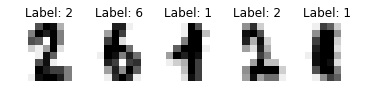

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline

digits = datasets.load_digits()

# choose some random images to display
indices = np.arange(len(digits.images))
display = np.random.choice(indices, size=5)

for i, image in enumerate(digits.images[display]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title("Label: %d" % digits.target[display[i]])
plt.show()
    
mnist_data = digits.images
mnist_data = mnist_data[:,np.newaxis,:,:]
labels = digits.target


In [2]:
from sklearn.model_selection import train_test_split

train_to_test_ratio = 0.8
X_train, X_test, Y_train, Y_test = train_test_split(mnist_data, labels, train_size=train_to_test_ratio)


/home/andreas/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
class ConvolutionalNeuralNetwork:
    def __init__(self, X_data, Y_data):
        self.X_data = X_data
        self.Y_data = Y_data
        self.n_inputs, self.depth, self.input_width, self.input_height = X_data.shape
        
        self.eta = 1E-6
        self.lmbd = 0.1
        
        self.padding = 1
        self.receptive_field = 3
        self.stride = 1
        self.downsampling = 2
        
        self.n_filters_conv = 3
        self.n_neurons_flattened = int(self.n_filters_conv*self.input_width*self.input_height)
        self.n_neurons_connected = 10
        self.n_categories = 10
        
        self.output_width = int((self.input_width - self.receptive_field + 2 * self.padding) / self.stride + 1)
        self.output_height = int((self.input_height - self.receptive_field + 2 * self.padding) / self.stride + 1)
        self.downsampling_width = int(self.output_width / self.downsampling)
        self.downsampling_height = int(self.output_height / self.downsampling)
        
        self.create_biases_and_weights()

    def create_biases_and_weights(self):
        self.weights_conv = np.random.randn(self.n_filters_conv, self.depth, self.receptive_field, self.receptive_field)
        self.bias_conv = np.zeros(self.n_filters_conv)
        
        self.weights_connected = np.random.randn(self.n_neurons_flattened, self.n_neurons_connected)
        self.bias_connected = np.zeros(self.n_neurons_connected)
        
        self.weights_output = np.random.randn(self.n_neurons_connected, self.n_categories)
        self.bias_output = np.zeros(self.n_categories)
    
    def feed_forward(self):
        # Convolution layer
        self.z1 = np.zeros((self.n_inputs, self.n_filters_conv, self.output_width, self.output_height))
        for n in range(self.n_inputs):
            X_padded = np.pad(self.X_data[n,:,:,:], ((0,0),(self.padding,self.padding),(self.padding,self.padding)), 
                              'constant')
            for f in range(self.n_filters_conv):
                for w in range(self.output_width):
                    for h in range(self.output_height):
                        w1 = w*self.stride
                        w2 = w*self.stride + self.receptive_field
                        h1 = h*self.stride
                        h2 = h*self.stride + self.receptive_field
                        matrix_slice = X_padded[:,w1:w2,h1:h2]
                        self.z1[n, f, w, h] = np.sum(matrix_slice*self.weights_conv[f,:,:,:])
        self.a1 = np.maximum(self.z1, 0)
        
        # 2x2 downsampling layer
        self.z2 = np.zeros_like(self.a1)
        for n in range(self.n_inputs):
            for w in range(self.downsampling_width):
                for h in range(self.downsampling_height):
                    w1 = w*self.downsampling
                    w2 = w*self.downsampling + self.downsampling
                    h1 = h*self.downsampling
                    h2 = h*self.downsampling + self.downsampling
                    matrix_slice = self.a1[n,:,w1:w2,h1:h2]
                    matrix_slice[matrix_slice != matrix_slice.max()] = 0
                    self.z2[n,:,w1:w2,h1:h2] = matrix_slice
        self.a2 = np.maximum(self.z2, 0)
        
        # Fully connected layer
        self.downsampled_array = self.a2.reshape(-1, self.n_neurons_flattened)
        self.z3 = np.dot(self.downsampled_array, self.weights_connected) + self.bias_connected
        self.a3 = np.maximum(self.z3, 0)
        
        # Output layer
        exp_term = np.exp(self.a3)
        self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        self.probabilities[np.abs(self.probabilities) < 1E-16] = 0
        
    def feed_forward_out(self, X):
        # Convolution layer
        n_inputs = X.shape[0]
        z1 = np.zeros((n_inputs, self.n_filters_conv, self.output_width, self.output_height))
        for n in range(n_inputs):
            X_padded = np.pad(X[n,:,:,:], ((0,0),(self.padding,self.padding),(self.padding,self.padding)), 
                              'constant')
            for f in range(self.n_filters_conv):
                for w in range(self.output_width):
                    for h in range(self.output_height):
                        w1 = w*self.stride
                        w2 = w*self.stride + self.receptive_field
                        h1 = h*self.stride
                        h2 = h*self.stride + self.receptive_field
                        matrix_slice = X_padded[:,w1:w2,h1:h2]
                        z1[n, f, w, h] = np.sum(matrix_slice*self.weights_conv[f,:,:,:])
        a1 = np.maximum(z1, 0)
        
        # 2x2 downsampling layer
        z2 = np.zeros_like(a1)
        for n in range(n_inputs):
            for w in range(self.downsampling_width):
                for h in range(self.downsampling_height):
                    w1 = w*self.downsampling
                    w2 = w*self.downsampling + self.downsampling
                    h1 = h*self.downsampling
                    h2 = h*self.downsampling + self.downsampling
                    matrix_slice = a1[n,:,w1:w2,h1:h2]
                    matrix_slice[matrix_slice != matrix_slice.max()] = 0
                    z2[n,:,w1:w2,h1:h2] = matrix_slice
        a2 = np.maximum(z2, 0)
        
        # Fully connected layer
        downsampled_array = a2.reshape(-1, self.n_neurons_flattened)
        z3 = np.dot(downsampled_array, self.weights_connected) + self.bias_connected
        a3 = np.maximum(z3, 0)
        
        # Output layer
        exp_term = np.exp(a3)
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        probabilities[np.abs(probabilities) < 1E-16] = 0
        return probabilities
    
    def backpropagation(self):
        # Output layer
        error_output = self.probabilities
        error_output[range(self.n_inputs), self.Y_data] -= 1
        self.weights_output_gradient = np.dot(self.a3.T, error_output)
        self.bias_output_gradient = np.sum(error_output)
        
        # Fully connected layer
        error_connected = np.dot(error_output, self.weights_output.T)*(self.a3 >=0)
        self.weights_connected_gradient = np.dot(self.downsampled_array.T, error_connected)
        self.bias_connected_gradient = np.sum(error_connected)
        
        # 2x2 downsampling layer
        error_downsampling = np.dot(error_connected, self.weights_connected.T)*(self.downsampled_array >=0)
        error_downsampling = error_downsampling.reshape(-1, self.n_filters_conv, self.output_width, self.output_height)
        
        # Convolutional layer
        error_conv = error_downsampling
        self.weights_conv_gradient = np.zeros_like(self.weights_conv)
        for n in range(self.n_inputs):
            X_padded = np.pad(self.X_data[n,:,:,:], ((0,0),(self.padding,self.padding),(self.padding,self.padding)), 
                              'constant')
            for f in range(self.n_filters_conv):
                for w in range(self.output_width):
                    for h in range(self.output_height):
                        w1 = w*self.stride
                        w2 = w*self.stride + self.receptive_field
                        h1 = h*self.stride
                        h2 = h*self.stride + self.receptive_field
                        matrix_slice = X_padded[:,w1:w2,h1:h2]
                        self.weights_conv_gradient[f,:,:,:] += X_padded[:,w1:w2,h1:h2]*error_conv[n, f, w, h]
        self.bias_conv_gradient = np.sum(error_conv)
        
        if self.lmbd > 0.0:
            self.weights_output_gradient += self.lmbd * self.weights_output
            self.weights_connected_gradient += self.lmbd * self.weights_connected
            self.weights_conv_gradient += self.lmbd * self.weights_conv
        
        self.weights_output -= self.eta * self.weights_output_gradient
        self.bias_output -= self.eta * self.bias_output_gradient
        self.weights_connected -= self.eta * self.weights_connected_gradient
        self.bias_connected -= self.eta * self.bias_connected_gradient
        self.weights_conv -= self.eta * self.weights_conv_gradient
        self.bias_conv -= self.eta * self.bias_conv_gradient
    
    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

In [4]:
import warnings
from sklearn.metrics import accuracy_score
from tqdm import tqdm_notebook

warnings.filterwarnings("ignore")

cnn = ConvolutionalNeuralNetwork(X_train, Y_train)
pred = cnn.predict(X_test)
print(accuracy_score(pred, Y_test))

for i in tqdm_notebook(range(10)):
    cnn.feed_forward()
    cnn.backpropagation()

pred = cnn.predict(X_test)
print(accuracy_score(pred, Y_test))


0.09722222222222222



0.09722222222222222


In [5]:
import tensorflow as tf

class CNNModel:
    def __init__(
        self,
        input_width,
        input_height,
        n_filters=10,
        n_neurons_connected=50,
        n_categories=10,
        depth=1,
        receptive_field=3,
        stride=1,
        padding=1,
        eta=0.1,
    ):
        
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

        self.input_width = input_width
        self.input_height = input_height
        
        self.n_filters = n_filters
        self.n_downsampled = int(input_width*input_height*n_filters / 4)
        self.n_neurons_connected = n_neurons_connected
        self.n_categories = n_categories
        
        self.depth = depth
        self.receptive_field = receptive_field
        self.stride = stride
        self.strides = [self.stride, self.stride, self.stride, self.stride]
        self.padding = padding
        self.eta = eta
        
        self.create_placeholders()
        self.create_CNN()
        self.create_loss()
        self.create_accuracy()
        self.create_optimiser()
    
    def create_placeholders(self):
        with tf.name_scope('data'):
            self.X = tf.placeholder(tf.float32, shape=(None, self.input_width, self.input_height, self.depth), name='X_data')
            self.Y = tf.placeholder(tf.float32, shape=(None, self.n_categories), name='Y_data')
    
    def create_CNN(self):
        with tf.name_scope('CNN'):
            
            # Convolutional layer
            W_conv = self.weight_variable([self.receptive_field, self.receptive_field, self.depth, self.n_filters], name='conv', dtype=tf.float32)
            b_conv = self.weight_variable([self.n_filters], name='conv', dtype=tf.float32)
            z_conv = tf.nn.conv2d(self.X, W_conv, self.strides, padding='SAME', name='conv') + b_conv
            a_conv = tf.nn.relu(z_conv)
            
            # 2x2 max pooling
            a_pool = tf.nn.max_pool(a_conv, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME', name='pool')
            
            # Fully connected layer
            a_pool_flat = tf.reshape(a_pool, [-1, self.n_downsampled])
            W_fc = self.weight_variable([self.n_downsampled, self.n_neurons_connected], name='fc', dtype=tf.float32)
            b_fc = self.bias_variable([self.n_neurons_connected], name='fc', dtype=tf.float32)
            a_fc = tf.nn.relu(tf.matmul(a_pool_flat, W_fc) + b_fc)
            
            # Output layer
            W_out = self.weight_variable([self.n_neurons_connected, self.n_categories], name='out', dtype=tf.float32)
            b_out = self.bias_variable([self.n_categories], name='out', dtype=tf.float32)
            self.z_out = tf.matmul(a_fc, W_out) + b_out
    
    def create_loss(self):
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.Y, logits=self.z_out))

    def create_accuracy(self):
        with tf.name_scope('accuracy'):
            correct_prediction = tf.equal(tf.argmax(self.Y,1), tf.argmax(self.z_out, 1))
            correct_prediction = tf.cast(correct_prediction, tf.float32)
            self.accuracy = tf.reduce_mean(correct_prediction)
    
    def create_optimiser(self):
        with tf.name_scope('optimizer'):
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.eta).minimize(self.loss, global_step=self.global_step)
            
    def weight_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name, dtype=dtype)
    
    def bias_variable(self, shape, name='', dtype=tf.float32):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name, dtype=dtype)

In [6]:
from keras.utils import to_categorical

mnist_data = mnist_data[:,0,:,:]
mnist_data = mnist_data[:,:,:,np.newaxis]

train_to_test_ratio = 0.8
X_train, X_test, Y_train, Y_test = train_test_split(mnist_data, labels, train_size=train_to_test_ratio)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

Using TensorFlow backend.


In [7]:
CNN = CNNModel(8, 8)

n_inputs = X_train.shape[0]
batch_size = 100
epochs = 100
iterations = n_inputs // batch_size
data_indices = np.arange(n_inputs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        for j in range(iterations):
            chosen_datapoints = np.random.choice(data_indices, size=batch_size, replace=False)
            batch_X, batch_Y = X_train[chosen_datapoints], Y_train[chosen_datapoints]
            
            sess.run([CNN.loss, CNN.optimizer],
                     feed_dict={CNN.X: batch_X,
                                CNN.Y: batch_Y})
            accuracy = sess.run(CNN.accuracy,
                                feed_dict={CNN.X: batch_X,
                                           CNN.Y: batch_Y})
            step = sess.run(CNN.global_step)
    
    train_loss, train_accuracy = sess.run([CNN.loss, CNN.accuracy],
                                          feed_dict={CNN.X: X_train,
                                                     CNN.Y: Y_train})
    
    test_loss, test_accuracy = sess.run([CNN.loss, CNN.accuracy],
                                        feed_dict={CNN.X: X_test,
                                                   CNN.Y: Y_test})
    
    print("Train accuracy: %.3f" % train_accuracy)
    print("Test accuracy: %.3f" % test_accuracy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Train accuracy: 1.000
Test accuracy: 0.981
